# Tutorial 2: Simulating Interpolated Designs

In this tutorial we will learn how to simulate designs obtained from the SQuADDS Database. We will be using **Ansys HFSS** as the simulator backend in this tutorial.

**Warning: This tutorial will not run on Mac OS since Ansys HFSS is not available on Mac**

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from squadds import SQuADDS_DB

db = SQuADDS_DB()
db.select_system(["qubit","cavity_claw"])
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_coupler("NCap")
db.show_selections()
df = db.create_system_df()
# df

Selected qubit:  TransmonCross
Selected cavity:  RouteMeander
Selected coupler:  NCap
Selected system:  ['qubit', 'cavity_claw']


In [5]:
from squadds import Analyzer

In [6]:
analyzer = Analyzer(db)

In [7]:
analyzer.selected_system

['qubit', 'cavity_claw']

In [8]:
target_params = {
                "qubit_frequency_GHz": 4,
                "cavity_frequency_GHz": 6.2,
                "kappa_kHz": 5,
                "resonator_type":"half",
                "anharmonicity_MHz": -200,
                "g_MHz": 70}

In [9]:
results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)
results

 c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\squadds\core\analysis.py: 274


,design_options_qubit,design_tool_qubit,PI_qubit,date_created_qubit,group_qubit,institution_qubit,uploader_qubit,renderer_options_qubit,setup_qubit,simulator_qubit,...,cavity_frequency_GHz,kappa_kHz,units_cavity_claw,design_options,EC,EJ,EJEC,qubit_frequency_GHz,anharmonicity_MHz,g_MHz
37310,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"Eli Levenson-Falk, PhD",2023-09-20-142549,LFL,USC,Andre Kuo,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,...,6.927222,0.636514,Hz,{'cavity_claw_options': {'coupling_type': 'NCa...,0.180488,12.278081,68.027038,4.021247,-202.397239,70.289253
37324,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"Eli Levenson-Falk, PhD",2023-09-20-142549,LFL,USC,Andre Kuo,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,...,6.927222,0.636514,Hz,{'cavity_claw_options': {'coupling_type': 'NCa...,0.180488,12.278081,68.027038,4.021247,-202.397239,70.289253
24703,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"Eli Levenson-Falk, PhD",2023-09-20-142549,LFL,USC,Andre Kuo,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,...,6.910772,0.635006,Hz,{'cavity_claw_options': {'coupling_type': 'NCa...,0.171785,12.278081,71.473512,3.927835,-191.988717,70.912301


## Get Target Interpolated Design
Find the best geometries for your desired Hamiltonian parameters the same way as in [Tutorial 1](https://lfl-lab.github.io/SQuADDS/source/tutorials/Tutorial-1_Getting_Started_with_SQuADDS.html#Making-Systems-out-of-Circuit-QED-Elements):

In [5]:
from squadds import SQuADDS_DB

db = SQuADDS_DB()
db.select_system("qubit")
db.select_qubit("TransmonCross")
df = db.create_system_df()
# df

Both system and component name must be defined.


AttributeError: 'NoneType' object has no attribute 'columns'

In [3]:
from squadds import Analyzer
analyzer = Analyzer(db)

target_params={"qubit_frequency_GHz": 4, "anharmonicity_MHz": -200}

results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)
results

 c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\squadds\core\analysis.py: 274


,design_options,design_tool,PI,date_created,group,institution,uploader,renderer_options,setup,simulator,...,cross_to_claw,cross_to_cross,cross_to_ground,ground_to_ground,units,EC,EJ,EJEC,qubit_frequency_GHz,anharmonicity_MHz
643,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,...,5.25204,102.49025,102.49025,255.94708,fF,0.179783,12.278081,68.293901,4.013771,-201.551532
1862,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,...,2.89095,104.64079,104.64079,233.88902,fF,0.180135,12.278081,68.160441,4.017505,-201.973599
1714,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,...,2.62986,104.89818,104.89818,230.69451,fF,0.180141,12.278081,68.158096,4.017570,-201.981031


In [4]:
best_device = results.iloc[0]
best_device

design_options         {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...
design_tool                                                 qiskit-metal
PI                                                Eli Levenson-Falk, PhD
date_created                                           2023-09-20-142547
group                                                                LFL
institution                                                          USC
uploader                                                       Andre Kuo
renderer_options       {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...
setup                  {'auto_increase_solution_order': True, 'enable...
simulator                                                     Ansys HFSS
claw_to_claw                                                   106.91739
claw_to_ground                                                 101.13161
cross_to_claw                                                    5.25204
cross_to_cross                                     

## Simulate the Target Design

Once you have the target design (in this case in Qiskit Metal format), you can then simulate it in whichever application you choose. However, we provide a native API to make it easier to get started with simulation on Ansys HFSS (support for AWS Palace will be provided hopefully in the near future!).   

We use the `AnsysSimulator` class to run simulations:

In [5]:
from squadds import AnsysSimulator

The `AnsysSimulator` object takes the analyzer from before and the target "best device" that you want to simulate as parameters.

In [6]:
ansys_simulator = AnsysSimulator(analyzer, best_device)

selected system: qubit


In [7]:
best_device

design_options         {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...
design_tool                                                 qiskit-metal
claw_to_claw                                                   106.91739
claw_to_ground                                                 101.13161
cross_to_claw                                                    5.25204
cross_to_cross                                                 102.49025
cross_to_ground                                                102.49025
ground_to_ground                                               255.94708
units                                                                 fF
renderer_options       {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...
setup                  {'auto_increase_solution_order': True, 'enable...
simulator                                                     Ansys HFSS
PI                                                Eli Levenson-Falk, PhD
date_created                                       

We can view the geometry and simulation setup from the database entry for our best device as follows:

In [8]:
best_device_geometry = best_device["design_options"]
best_device_geometry

{'aedt_hfss_capacitance': 0,
 'aedt_hfss_inductance': 9.686e-09,
 'aedt_q3d_capacitance': 0,
 'aedt_q3d_inductance': 1e-08,
 'chip': 'main',
 'connection_pads': {'readout': {'claw_cpw_length': '40um',
   'claw_cpw_width': '10um',
   'claw_gap': '5.1um',
   'claw_length': '190um',
   'claw_width': '15um',
   'connector_location': '90',
   'connector_type': '0',
   'ground_spacing': '10um'}},
 'cross_gap': '30um',
 'cross_length': '210um',
 'cross_width': '30um',
 'gds_cell_name': 'my_other_junction',
 'hfss_capacitance': 0,
 'hfss_inductance': 9.686e-09,
 'hfss_mesh_kw_jj': 7e-06,
 'hfss_resistance': 0,
 'layer': '1',
 'orientation': '-90',
 'pos_x': '-1500um',
 'pos_y': '1200um',
 'q3d_capacitance': 0,
 'q3d_inductance': '10nH',
 'q3d_mesh_kw_jj': 7e-06,
 'q3d_resistance': 0}

Now, let's say we want to change some parameter in the design, for example, the `cross_length`, just for demonstration purposes.

In [9]:
best_device_geometry["cross_length"] = '310um'
best_device_geometry

{'aedt_hfss_capacitance': 0,
 'aedt_hfss_inductance': 9.686e-09,
 'aedt_q3d_capacitance': 0,
 'aedt_q3d_inductance': 1e-08,
 'chip': 'main',
 'connection_pads': {'readout': {'claw_cpw_length': '40um',
   'claw_cpw_width': '10um',
   'claw_gap': '5.1um',
   'claw_length': '190um',
   'claw_width': '15um',
   'connector_location': '90',
   'connector_type': '0',
   'ground_spacing': '10um'}},
 'cross_gap': '30um',
 'cross_length': '310um',
 'cross_width': '30um',
 'gds_cell_name': 'my_other_junction',
 'hfss_capacitance': 0,
 'hfss_inductance': 9.686e-09,
 'hfss_mesh_kw_jj': 7e-06,
 'hfss_resistance': 0,
 'layer': '1',
 'orientation': '-90',
 'pos_x': '-1500um',
 'pos_y': '1200um',
 'q3d_capacitance': 0,
 'q3d_inductance': '10nH',
 'q3d_mesh_kw_jj': 7e-06,
 'q3d_resistance': 0}

In [10]:
best_device_sim_setup = best_device["setup"]
best_device_sim_setup

{'auto_increase_solution_order': True,
 'enabled': True,
 'freq_ghz': 5.0,
 'max_passes': 30,
 'min_converged_passes': 1,
 'min_passes': 2,
 'name': 'sweep_setup',
 'percent_error': 0.1,
 'percent_refinement': 30,
 'reuse_selected_design': False,
 'reuse_setup': False,
 'run': {'box_plus_buffer': True,
  'components': array(['Q'], dtype=object),
  'name': 'sweep_v2.0',
  'open_terminations': array([array(['Q', 'readout'], dtype=object)], dtype=object)},
 'save_fields': False,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

Then, we simulate our device with Ansys HFSS. In this case, we are simulating a TransmonCross object to get its corresponding capacitance matrix.

In [11]:
ansys_results = ansys_simulator.simulate(best_device)
ansys_results

INFO 01:20PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:20PM [load_ansys_project]: 	Opened Ansys App
INFO 01:20PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:20PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Users/lfl/Documents/Ansoft/
	Project:   Project20


the parameters ['run'] are unsupported, so they have been ignored


INFO 01:20PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
WARNING 01:20PM [connect_setup]: 	No design setup detected.
WARNING 01:20PM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:20PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:20PM [connect]: 	Connected to project "Project20" and design "CavitySweep_hfss" 😀 

INFO 01:20PM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d2 [Solution type: Q3D]
WARNING 01:20PM [connect_setup]: 	No design setup detected.
WARNING 01:20PM [connect_setup]: 	Creating Q3D default setup.
INFO 01:20PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:20PM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:20PM [analyze]: Analyzing setup sweep_setup
INFO 01:21PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpkt2nexhj.txt, C, , sweep_setup:LastAdaptive, 

{'design': {'design_options': {'pos_x': '-1500um',
   'pos_y': '1200um',
   'orientation': '-90',
   'chip': 'main',
   'layer': '1',
   'connection_pads': {'readout': {'connector_type': '0',
     'claw_length': '190um',
     'ground_spacing': '10um',
     'claw_width': '15um',
     'claw_gap': '5.1um',
     'claw_cpw_length': '40um',
     'claw_cpw_width': '10um',
     'connector_location': '90'}},
   'cross_width': '30um',
   'cross_length': '310um',
   'cross_gap': '30um',
   'hfss_inductance': 9.686e-09,
   'hfss_capacitance': 0,
   'hfss_resistance': 0,
   'hfss_mesh_kw_jj': 7e-06,
   'q3d_inductance': '10nH',
   'q3d_capacitance': 0,
   'q3d_resistance': 0,
   'q3d_mesh_kw_jj': 7e-06,
   'gds_cell_name': 'my_other_junction',
   'aedt_q3d_inductance': 1e-08,
   'aedt_q3d_capacitance': 0,
   'aedt_hfss_inductance': 9.686e-09,
   'aedt_hfss_capacitance': 0},
  'design_tool': 'Qiskit Metal'},
 'sim_options': {'sim_type': 'lom',
  'setup': {'name': 'sweep_setup',
   'reuse_selected_de

After the simulation is finished, we have the option to take screenshots of our design in the renderer and in Qiskit Metal to verify our geometry visually, as follows:

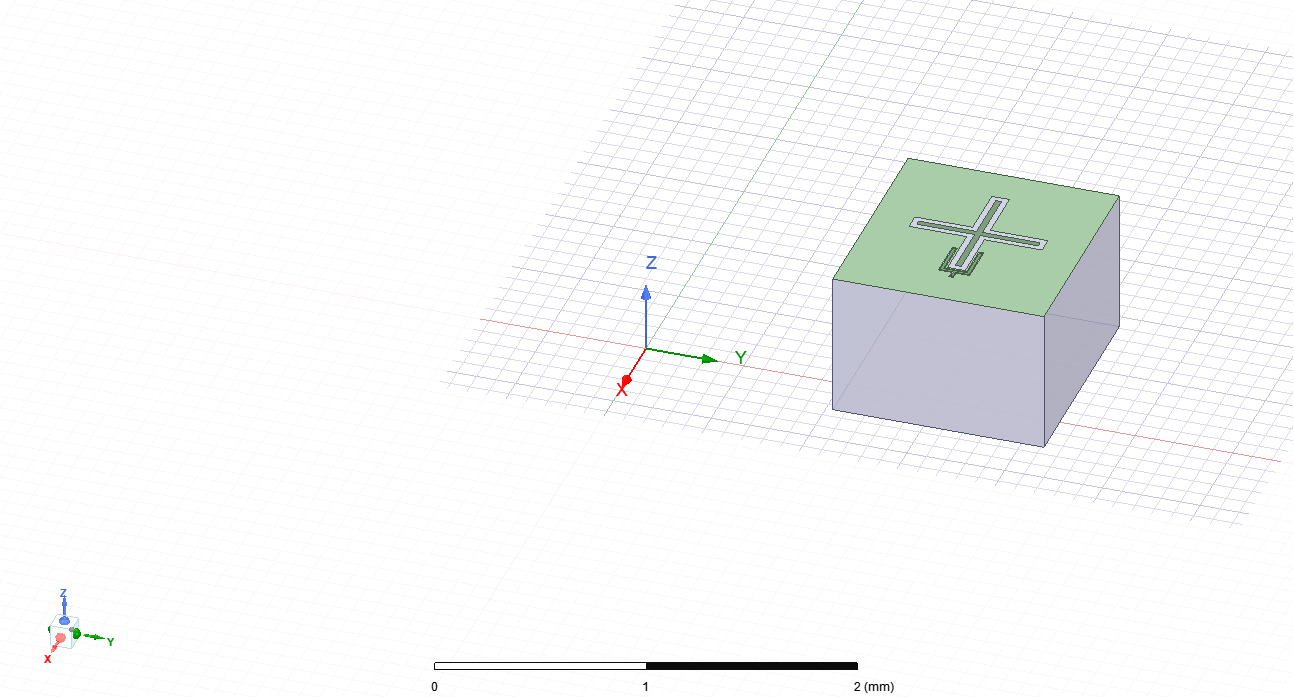

In [12]:
ansys_simulator.get_renderer_screenshot()

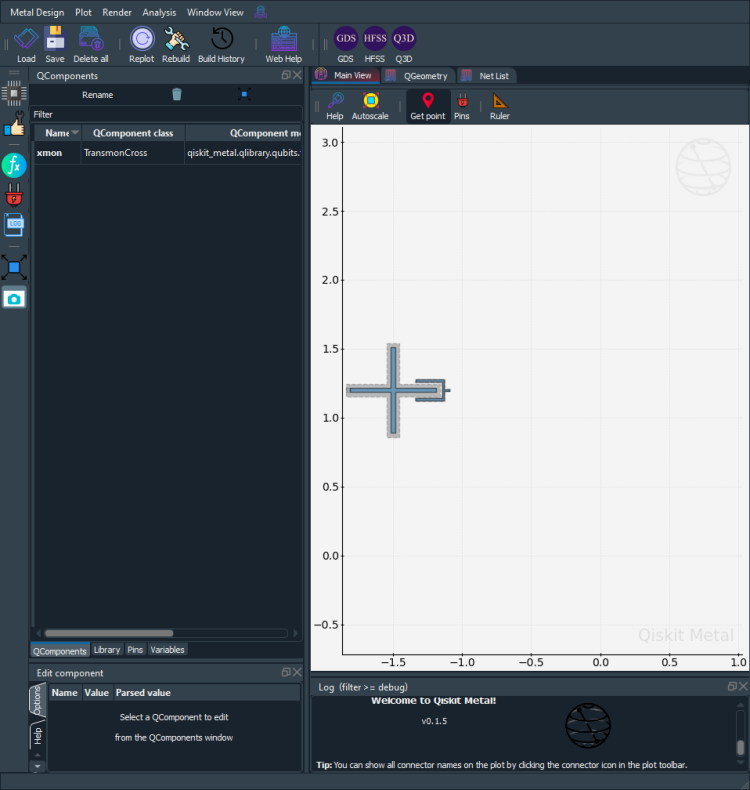

In [13]:
ansys_simulator.get_design_screenshot()

We can also analyze the simulated capacitance matrix results using the `get_xmon_info()` function, which returns the `qubit_anharmonicity_MHz` and  `qubit_frequency_GHz`.

In [14]:
ansys_simulator.get_xmon_info(ansys_results)

qubit anharmonicity = -129 MHz 
qubit frequency = 3.827 GHz


{'qubit_frequency_GHz': 3.8271923164431207,
 'anharmonicity_MHz': -128.9175587847744}

### Extracting the data needed for contributing to the dataset

Suppose that we wanted to contribute this "new" design and simulation results to `SQuADDS_DB`.

We need to first, extract the correct data that will be neccessary for contributing the results.

First, we get the `design` dictionary:

In [15]:
design_dict = ansys_results["design"]
design_dict

{'design_options': {'pos_x': '-1500um',
  'pos_y': '1200um',
  'orientation': '-90',
  'chip': 'main',
  'layer': '1',
  'connection_pads': {'readout': {'connector_type': '0',
    'claw_length': '190um',
    'ground_spacing': '10um',
    'claw_width': '15um',
    'claw_gap': '5.1um',
    'claw_cpw_length': '40um',
    'claw_cpw_width': '10um',
    'connector_location': '90'}},
  'cross_width': '30um',
  'cross_length': '310um',
  'cross_gap': '30um',
  'hfss_inductance': 9.686e-09,
  'hfss_capacitance': 0,
  'hfss_resistance': 0,
  'hfss_mesh_kw_jj': 7e-06,
  'q3d_inductance': '10nH',
  'q3d_capacitance': 0,
  'q3d_resistance': 0,
  'q3d_mesh_kw_jj': 7e-06,
  'gds_cell_name': 'my_other_junction',
  'aedt_q3d_inductance': 1e-08,
  'aedt_q3d_capacitance': 0,
  'aedt_hfss_inductance': 9.686e-09,
  'aedt_hfss_capacitance': 0},
 'design_tool': 'Qiskit Metal'}

Then, we can get the `sim_options` dictionary:

In [16]:
sim_options_dict = ansys_results["sim_options"]
sim_options_dict

{'sim_type': 'lom',
 'setup': {'name': 'sweep_setup',
  'reuse_selected_design': False,
  'reuse_setup': False,
  'freq_ghz': 5.0,
  'save_fields': False,
  'enabled': True,
  'max_passes': 30,
  'min_passes': 2,
  'min_converged_passes': 1,
  'percent_error': 0.1,
  'percent_refinement': 30,
  'auto_increase_solution_order': True,
  'solution_order': 'High',
  'solver_type': 'Iterative',
  'run': {'name': 'LOMv2.0',
   'components': ['xmon'],
   'open_terminations': [('xmon', 'readout')],
   'box_plus_buffer': True}},
 'renderer_options': {'Lj': '10nH',
  'Cj': 0,
  '_Rj': 0,
  'max_mesh_length_jj': '7um',
  'max_mesh_length_port': '7um',
  'project_path': None,
  'project_name': None,
  'design_name': None,
  'x_buffer_width_mm': 0.2,
  'y_buffer_width_mm': 0.2,
  'wb_threshold': '400um',
  'wb_offset': '0um',
  'wb_size': 5,
  'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
   'UserSpecifyName': '0',
   'UserSpecifyFolder': '0',
   'QuantityName': 'Mag_E',
   'PlotFolder': 'E F

And then the renderer options:

In [17]:
renderer_options_dict = ansys_results["sim_options"]["renderer_options"]
renderer_options_dict

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'max_mesh_length_port': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

And finally, the `sim_results` dictionary:

In this particular simulation, all of our results have units of femtoFarads, so we can just add a global `units` key with value `fF`.

In [18]:
sim_results_dict = ansys_results["sim_results"]
sim_results_dict.update({"units": "fF"})

We can then take the dictionaries that we have just created, and send them to a JSON file that we will use later on in Tutorial 3.

In [19]:
final_dict = dict(
    sim_options = dict(
        renderer_options = renderer_options_dict,
        setup = sim_options_dict["setup"],
        simulator = sim_options_dict["simulator"]
    ),
    design = design_dict,
    sim_results = sim_results_dict
)
final_dict

{'sim_options': {'renderer_options': {'Lj': '10nH',
   'Cj': 0,
   '_Rj': 0,
   'max_mesh_length_jj': '7um',
   'max_mesh_length_port': '7um',
   'project_path': None,
   'project_name': None,
   'design_name': None,
   'x_buffer_width_mm': 0.2,
   'y_buffer_width_mm': 0.2,
   'wb_threshold': '400um',
   'wb_offset': '0um',
   'wb_size': 5,
   'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
    'UserSpecifyName': '0',
    'UserSpecifyFolder': '0',
    'QuantityName': 'Mag_E',
    'PlotFolder': 'E Field',
    'StreamlinePlot': 'False',
    'AdjacentSidePlot': 'False',
    'FullModelPlot': 'False',
    'IntrinsicVar': "Phase='0deg'",
    'PlotGeomInfo_0': '1',
    'PlotGeomInfo_1': 'Surface',
    'PlotGeomInfo_2': 'FacesList',
    'PlotGeomInfo_3': '1'}},
  'setup': {'name': 'sweep_setup',
   'reuse_selected_design': False,
   'reuse_setup': False,
   'freq_ghz': 5.0,
   'save_fields': False,
   'enabled': True,
   'max_passes': 30,
   'min_passes': 2,
   'min_converged_passes': 1,


Let's save the dictionaries to a JSON file so that we can use it later on in [Tutorial 3](https://lfl-lab.github.io/SQuADDS/source/tutorials/Tutorial-3_Contributing_to_SQuADDS.html#Contributing-to-an-existing-configuration), where go over this process in more detail.

In [20]:
import json
with open("examples/single_xmon_lom.json", 'w') as outfile:
    json.dump(final_dict, outfile, indent=4)

## Simulating an Interpolated Qubit + Cavity device

This time, we look for a complete device, which includes a TransmonCross object coupled to a RouteMeander CPW and CoupledLineTee, as in Tutorial 1.

In [5]:
db.select_system(["qubit","cavity_claw"])
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_coupler("CLT")
merged_df = db.create_system_df()
merged_df

,design_options_qubit,design_tool_qubit,claw_to_claw,claw_to_ground,cross_to_claw,cross_to_cross,cross_to_ground,ground_to_ground,units_qubit,renderer_options,...,units_cavity_claw,setup_cavity_claw,simulator_cavity_claw,PI_cavity_claw,date_created_cavity_claw,group_cavity_claw,institution_cavity_claw,misc,uploader_cavity_claw,design_options
0,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,94.97421,90.86585,3.73363,158.40783,158.40783,311.25590,fF,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...",...,Hz,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-12-09-204334,LFL,USC,None,Andre Kuo,{'cavity_claw_options': {'coupling_type': 'CLT...
1,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,94.97421,90.86585,3.73363,158.40783,158.40783,311.25590,fF,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...",...,Hz,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-12-06-224829,LFL,USC,None,Andre Kuo,{'cavity_claw_options': {'coupling_type': 'CLT...
2,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,94.97421,90.86585,3.73363,158.40783,158.40783,311.25590,fF,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...",...,Hz,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-12-04-124953,LFL,USC,None,Andre Kuo,{'cavity_claw_options': {'coupling_type': 'CLT...
3,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,94.97421,90.86585,3.73363,158.40783,158.40783,311.25590,fF,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...",...,Hz,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-12-08-173545,LFL,USC,None,Andre Kuo,{'cavity_claw_options': {'coupling_type': 'CLT...
4,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,94.97421,90.86585,3.73363,158.40783,158.40783,311.25590,fF,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...",...,Hz,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-11-30-214122,LFL,USC,None,Andre Kuo,{'cavity_claw_options': {'coupling_type': 'CLT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18952,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,183.80802,168.04023,15.11184,214.45993,214.45993,454.60312,fF,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...",...,Hz,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-12-04-124953,LFL,USC,None,Andre Kuo,{'cavity_claw_options': {'coupling_type': 'CLT...
18953,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,183.80802,168.04023,15.11184,214.45993,214.45993,454.60312,fF,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...",...,Hz,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,"Eli Levenson-Falk, PhD",2024-01-24-130550,LFL,USC,,Andre Kuo,{'cavity_claw_options': {'coupling_type': 'CLT...
18954,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,183.80802,168.04023,15.11184,214.45993,214.45993,454.60312,fF,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...",...,Hz,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,"Eli Levenson-Falk, PhD",2024-01-24-133017,LFL,USC,,Andre Kuo,{'cavity_claw_options': {'coupling_type': 'CLT...
18955,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,183.80802,168.04023,15.11184,214.45993,214.45993,454.60312,fF,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...",...,Hz,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,"Eli Levenson-Falk, PhD",2024-01-24-135008,LFL,USC,,Andre Kuo,{'cavity_claw_options': {'coupling_type': 'CLT...


In [6]:
target_params = {
                "qubit_frequency_GHz": 4,
                "cavity_frequency_GHz": 6.2,
                "kappa_kHz": 120,
                "resonator_type":"quarter",
                "anharmonicity_MHz": -200,
                "g_MHz": 70}

In [7]:
analyzer = Analyzer(db)

results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)
results

 c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\squadds\core\analysis.py: 274


,design_options_qubit,design_tool_qubit,claw_to_claw,claw_to_ground,cross_to_claw,cross_to_cross,cross_to_ground,ground_to_ground,units_qubit,renderer_options,...,institution_cavity_claw,misc,uploader_cavity_claw,design_options,EC,EJ,EJEC,qubit_frequency_GHz,anharmonicity_MHz,g_MHz
15374,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,113.99245,107.65111,5.75841,112.70740,112.70740,274.49373,fF,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...",...,USC,None,Andre Kuo,{'cavity_claw_options': {'coupling_type': 'CLT...,0.163509,12.278081,75.091148,3.836546,-182.146844,68.095121
2914,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,105.76081,99.80185,5.38260,100.41444,100.41444,251.82560,fF,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...",...,USC,None,Andre Kuo,{'cavity_claw_options': {'coupling_type': 'CLT...,0.183089,12.278081,67.060878,4.048669,-205.518797,70.226899
10676,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,109.80541,103.57639,5.68548,105.83609,105.83609,261.84982,fF,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...",...,USC,None,Andre Kuo,{'cavity_claw_options': {'coupling_type': 'CLT...,0.173690,12.278081,70.689448,3.948506,-194.262296,70.978895


In [8]:
best_device = results.iloc[0]
best_device

design_options_qubit          {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...
design_tool_qubit                                                  qiskit-metal
claw_to_claw                                                          113.99245
claw_to_ground                                                        107.65111
cross_to_claw                                                           5.75841
cross_to_cross                                                         112.7074
cross_to_ground                                                        112.7074
ground_to_ground                                                      274.49373
units_qubit                                                                  fF
renderer_options              {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...
setup_qubit                   {'auto_increase_solution_order': True, 'enable...
simulator_qubit                                                      Ansys HFSS
PI_qubit                                

After getting our best result, we once again initialize our AnsysSimulator object, this time on our new system, and then simulate.

In [9]:
ansys_simulator = AnsysSimulator(analyzer, best_device)

selected system: ['qubit', 'cavity_claw']


Starting the Simulation

INFO 01:23PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:23PM [load_ansys_project]: 	Opened Ansys App
INFO 01:23PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:23PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Users/lfl/Documents/Ansoft/
	Project:   Project20


INFO 01:23PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 01:23PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:23PM [connect]: 	Connected to project "Project20" and design "CavitySweep_hfss" 😀 

INFO 01:23PM [connect_design]: 	Opened active design
	Design:    CavitySweep2 [Solution type: Eigenmode]
WARNING 01:23PM [connect_setup]: 	No design setup detected.
WARNING 01:23PM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:23PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:23PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


Sim rendered into HFSS!
{'mesh1': {'objects': ['prime_cpw_cplr', 'second_cpw_cplr', 'trace_cpw', 'readout_connector_arm_claw'], 'MaxLength': '7um'}}
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path C:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path C:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


INFO:Global:Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


pyaedt INFO: Project Project20 set to active.


INFO:Global:Project Project20 set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 01:23PM [get_setup]: 	Opened setup `test_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:23PM [analyze]: Analyzing setup test_setup
01:25PM 25s INFO [get_f_convergence]: Saved convergences to d:\andre\SQuADDS\tutorials\hfss_eig_f_convergence.csv


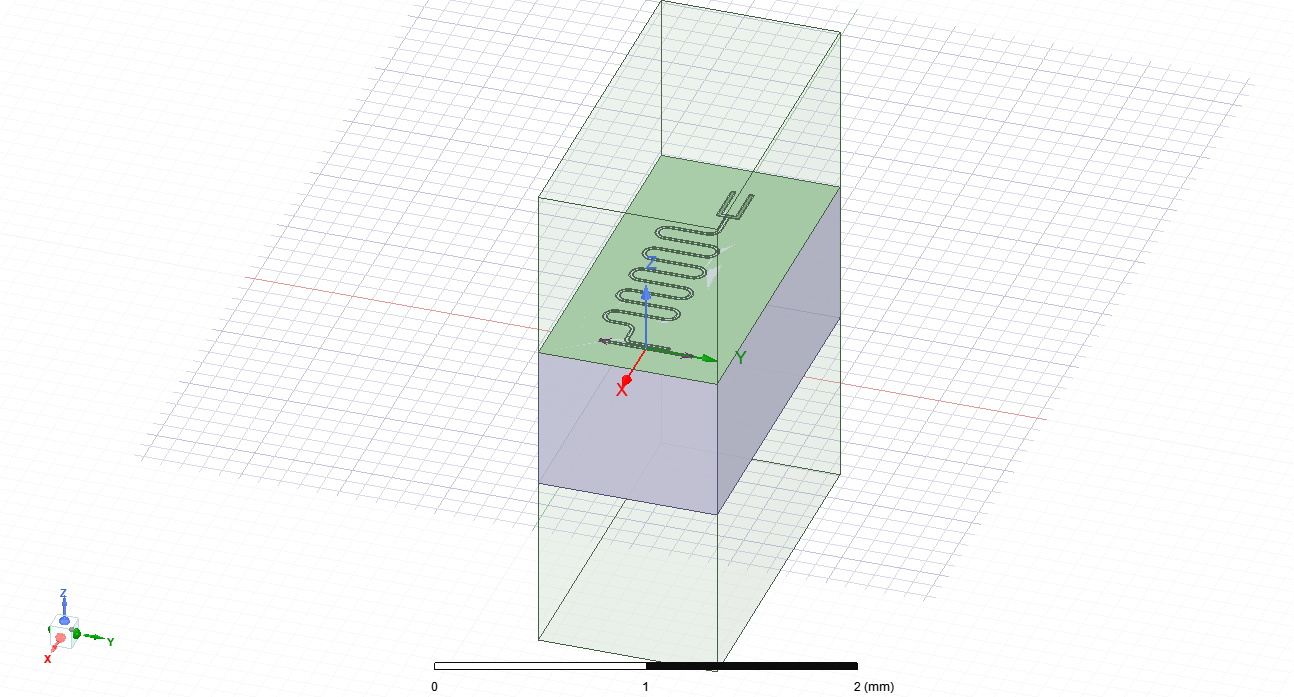

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
freq = 6.308 GHz
Q = 69884.7
kappa = 0.09 MHz
the parameters ['run'] are unsupported, so they have been ignored


INFO 01:25PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:25PM [load_ansys_project]: 	Opened Ansys App
INFO 01:25PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:25PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Users/lfl/Documents/Ansoft/
	Project:   Project20
INFO 01:25PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 01:25PM [get_setup]: 	Opened setup `test_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:25PM [connect]: 	Connected to project "Project20" and design "CavitySweep_hfss" 😀 

INFO 01:25PM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d3 [Solution type: Q3D]
WARNING 01:25PM [connect_setup]: 	No design setup detected.
WARNING 01:25PM [connect_setup]: 	Creating Q3D default setup.
INFO 01:25PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:25PM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)

{'sim_options': {'setup': {'eigenmode_setup': {'basis_order': 1,
    'max_delta_f': 0.05,
    'max_passes': 50,
    'min_converged': 1,
    'min_converged_passes': 2.0,
    'min_freq_ghz': 1,
    'min_passes': 1,
    'n_modes': 1,
    'name': 'Setup',
    'pct_refinement': 30,
    'reuse_selected_design': True,
    'reuse_setup': True,
    'vars': {'Cj': '0fF', 'Lj': '0nH'}},
   'LOM_setup': {'auto_increase_solution_order': True,
    'enabled': True,
    'freq_ghz': 5.0,
    'max_passes': 30,
    'min_converged_passes': 1,
    'min_passes': 2,
    'name': 'sweep_setup',
    'percent_error': 0.1,
    'percent_refinement': 30,
    'reuse_selected_design': False,
    'reuse_setup': False,
    'run': {'box_plus_buffer': True,
     'components': array(['Q'], dtype=object),
     'name': 'sweep_v2.0',
     'open_terminations': array([array(['Q', 'readout'], dtype=object)], dtype=object)},
    'save_fields': False,
    'solution_order': 'High',
    'solver_type': 'Iterative'}},
  'renderer_opt

In [10]:
ansys_results = ansys_simulator.simulate(best_device)
ansys_results

To extract the simulated Hamiltonian parameters, we look at the `sim_results` key in our `ansys_results` dictionary:

In [11]:
hamiltonian_results = ansys_results["sim_results"]
hamiltonian_results

{'cavity_frequency_GHz': 6307627234.08,
 'Q': 69884.74347231418,
 'kappa_kHz': 90257.57154820001,
 'g_MHz': 71.75039624612465,
 'anharmonicity_MHz': -179.0849797869427,
 'qubit_frequency_GHz': 4.451610365888763}

We can similarly get screenshots from Qiskit Metal and the Ansys renderer. Notice that the TransmonCross object and the cavity+claw object are rendered into the same design in Qiskit Metal. This is done purely out of convenience, and has no effect on the simulation results. This is shown in the renderer screenshots below, which show the TransmonCross and cavity+claw being rendered and simulated separately.

01:27PM 28s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



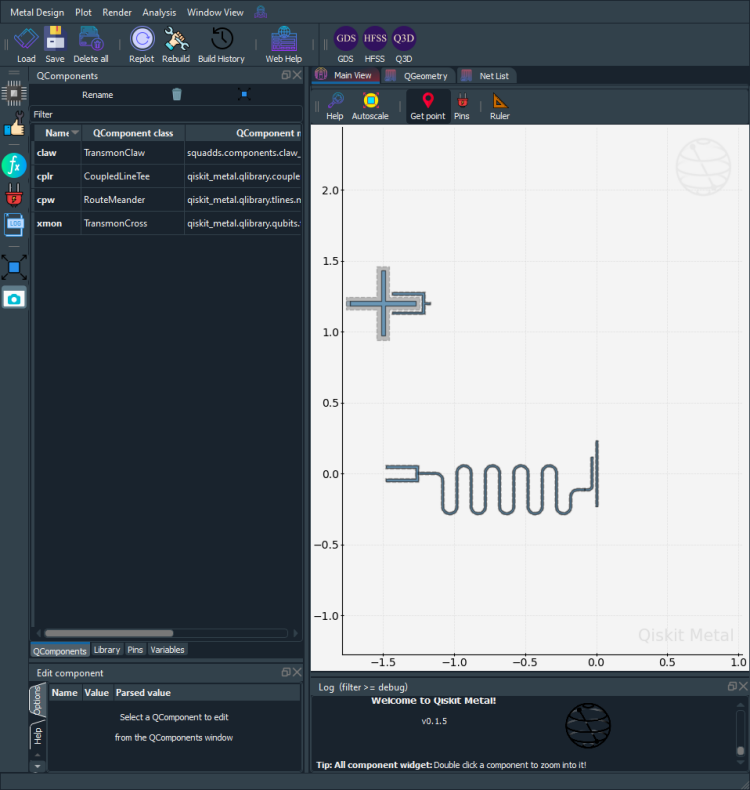

In [12]:
ansys_simulator.get_design_screenshot()

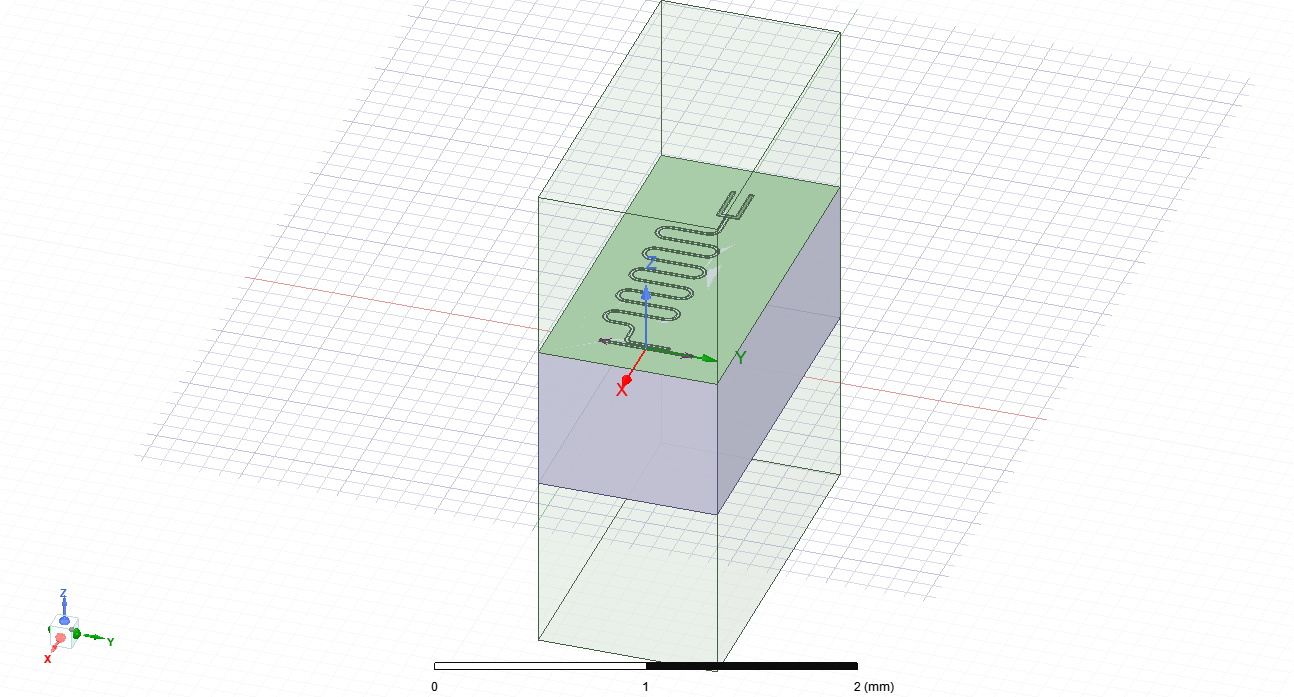

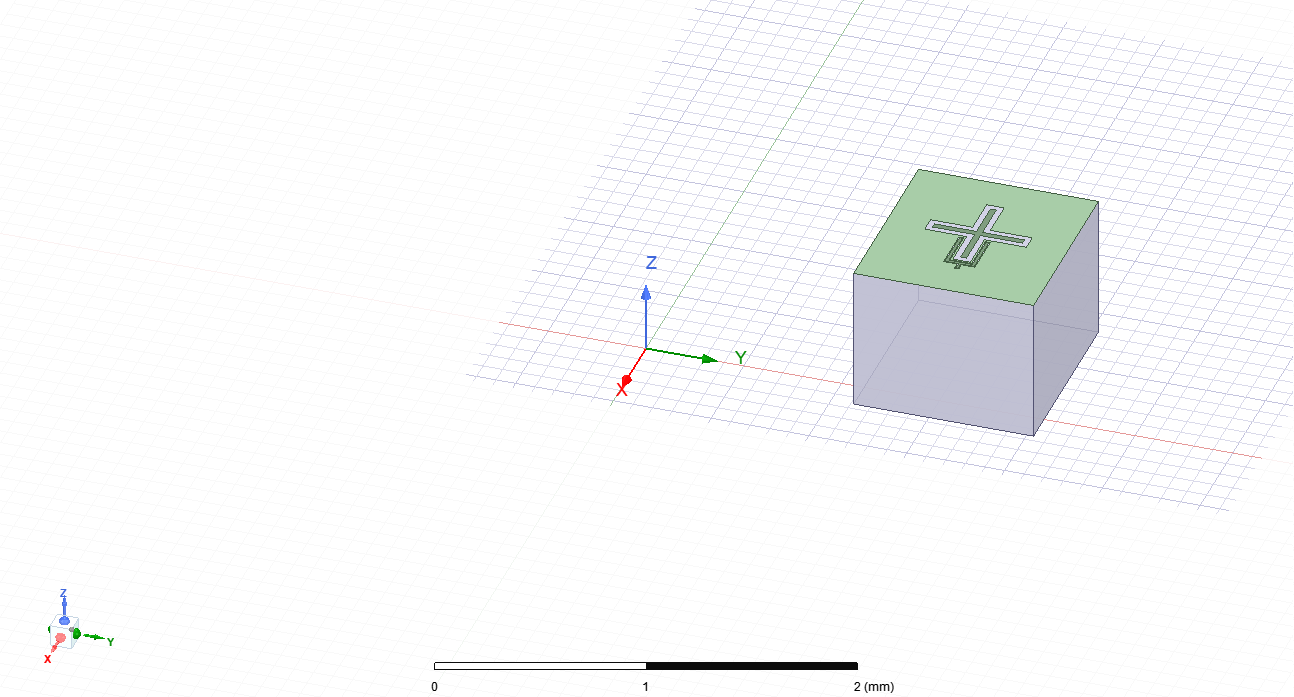

In [13]:
ansys_simulator.get_renderer_screenshot()

We can also plot our complete custom QubitCavity device in Qiskit Metal. 

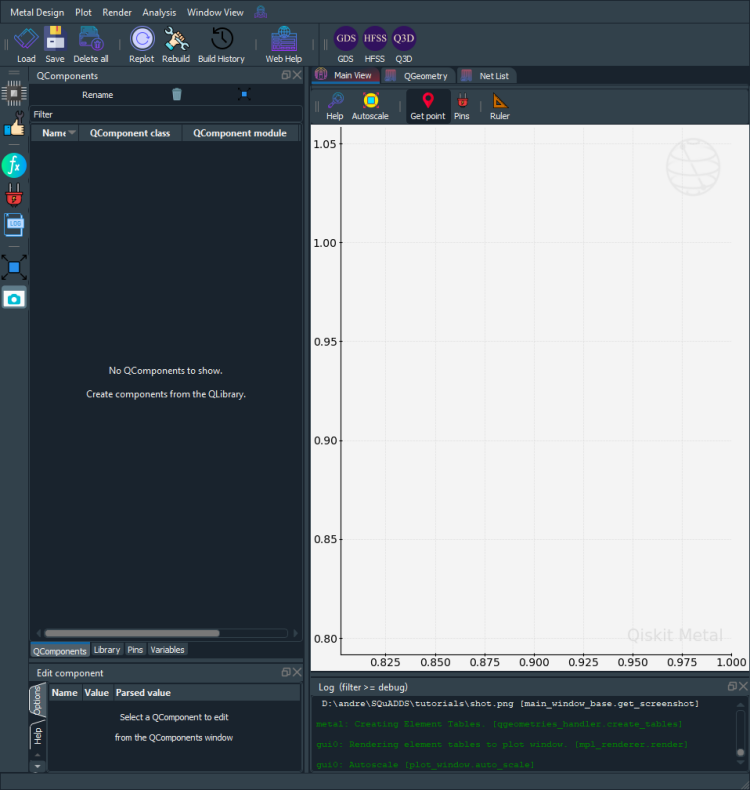

In [14]:
ansys_simulator.plot_device(ansys_results)

Finally, we can once again get relevant results dictionaries that will be useful if/when you decide to contribute your results to SQuADDS!

In [15]:
design_dict = ansys_results["design"]
design_dict

{'design_options': {'cavity_options': {'coupling_type': 'CLT',
   'coupler_options': {'coupling_length': '230um',
    'coupling_space': '7.9um',
    'down_length': '50um',
    'open_termination': False,
    'orientation': '-90',
    'prime_gap': '5.1um',
    'prime_width': '11.7um',
    'second_gap': '5.1um',
    'second_width': '11.7um'},
   'cpw_options': {'left_options': {'fillet': '49.9um',
     'lead': {'start_straight': '100um', 'end_straight': '50um'},
     'meander': {'spacing': '100um'},
     'pin_inputs': {'start_pin': {'component': 'cplr', 'pin': 'second_end'},
      'end_pin': {'component': 'claw', 'pin': 'readout'}},
     'total_length': '3900um',
     'trace_gap': '5.1um',
     'trace_width': '11.7um'}}},
  'qubit_options': {'aedt_hfss_capacitance': 0,
   'aedt_hfss_inductance': 9.686e-09,
   'aedt_q3d_capacitance': 0,
   'aedt_q3d_inductance': 1e-08,
   'chip': 'main',
   'connection_pads': {'readout': {'claw_cpw_length': '40um',
     'claw_cpw_width': '10um',
     'claw

In [16]:
sim_options_dict = ansys_results["sim_options"]
sim_options_dict

{'setup': {'eigenmode_setup': {'basis_order': 1,
   'max_delta_f': 0.05,
   'max_passes': 50,
   'min_converged': 1,
   'min_converged_passes': 2.0,
   'min_freq_ghz': 1,
   'min_passes': 1,
   'n_modes': 1,
   'name': 'Setup',
   'pct_refinement': 30,
   'reuse_selected_design': True,
   'reuse_setup': True,
   'vars': {'Cj': '0fF', 'Lj': '0nH'}},
  'LOM_setup': {'auto_increase_solution_order': True,
   'enabled': True,
   'freq_ghz': 5.0,
   'max_passes': 30,
   'min_converged_passes': 1,
   'min_passes': 2,
   'name': 'sweep_setup',
   'percent_error': 0.1,
   'percent_refinement': 30,
   'reuse_selected_design': False,
   'reuse_setup': False,
   'run': {'box_plus_buffer': True,
    'components': array(['Q'], dtype=object),
    'name': 'sweep_v2.0',
    'open_terminations': array([array(['Q', 'readout'], dtype=object)], dtype=object)},
   'save_fields': False,
   'solution_order': 'High',
   'solver_type': 'Iterative'}},
 'renderer_options': {'eigenmode_renderer_options': {'Lj': '1

In [17]:
sim_results_dict = ansys_results["sim_results"]
sim_results_dict

{'cavity_frequency_GHz': 6307627234.08,
 'Q': 69884.74347231418,
 'kappa_kHz': 90257.57154820001,
 'g_MHz': 71.75039624612465,
 'anharmonicity_MHz': -179.0849797869427,
 'qubit_frequency_GHz': 4.451610365888763}

We can once again update the units for our results. However, this time, the units are not all the same, so we must specify individual units.

In [18]:
sim_results_dict.update({
    "cavity_frequency_GHz_unit": "GHz",
    "g_MHz_unit": "MHz",
    "anharmonicity_MHz_unit": "MHz",
    "kappa_kHz_unit": "kHz",
    "qubit_frequency_GHz_unit": "GHz",
})
sim_results_dict

{'cavity_frequency_GHz': 6307627234.08,
 'Q': 69884.74347231418,
 'kappa_kHz': 90257.57154820001,
 'g_MHz': 71.75039624612465,
 'anharmonicity_MHz': -179.0849797869427,
 'qubit_frequency_GHz': 4.451610365888763,
 'cavity_frequency_GHz_unit': 'GHz',
 'g_MHz_unit': 'MHz',
 'anharmonicity_MHz_unit': 'MHz',
 'kappa_kHz_unit': 'kHz',
 'qubit_frequency_GHz_unit': 'GHz'}

## Simulating an Interdigitated Capacitor Device

We can now explore running a set of simulations sweeping over certain specified parameters for a device. In this case, we choose an interdigitated coupler device. Notice how the `total_length` parameter under `cpw_opts` in our `geometry_dict` is a `list` instead of a `String`. This lets our AnsysSimulator know that we wish to simulate this device [in this case] three total times, i.e. with the CPW `total_length=2000um`, with CPW `total_length = 4000um`, and with CPW `total_length = 7000um`. We can similarly specify sweeping over other parameters, using the same list syntax to denote which parameters should be swept over, and with respect to what dimensions, and the sweep will be done combinatorically with every combination of parameters specified.

In [16]:
ncap_sweep_dict = {
    "coupling_type": "NCAP",
    "geometry_dict": {
        "claw_opts": {
            "connection_pads": {
                "readout": {
                    "connector_location": "90",
                    "connector_type": "0",
                    "claw_length": "50um",
                    "ground_spacing": "10um",
                    "claw_gap": "5.1um",
                    "claw_width": "7um",
                    "claw_cpw_width": "11.7um",
                    "claw_cpw_length": "0um"
                }
            },
            "cross_width": "30um",
            "cross_length": "300um",
            "cross_gap": "30um",
            "orientation": "-90",
            "pos_x": "-1000um"
        },
        "cpw_opts": {
            "fillet": "49.9um",
            "total_length": ["2000um", "4000um", "7000um"],
            "trace_width": "11.7um",
            "trace_gap": "5.1um",
            "lead": {
                "start_straight": "50um"
            },
            "pin_inputs": {
                "start_pin": {
                    "component": "cplr",
                    "pin": "second_end"
                },
                "end_pin": {
                    "component": "claw",
                    "pin": "readout"
                }
            }
        },
        "cplr_opts": {
            'prime_width': '11.7um',
            'prime_gap': '5.1um',
            'second_width': '11.7um',
            'second_gap': '5.1um',
            'cap_gap': '5um',
            'cap_width': '10um',
            'cap_gap_ground': '5.1um',
            'finger_length': '30um',
            'finger_count': ['3','5','7'],
            'cap_distance': '50.9um',
        }
    }
}

We can also specify a setup for the sweep, though a default high-accuracy one will be assigned. Currently, we only support eigenmode and LOM sweeps for TransmonCross, CavityClaw, and InterdigitatedCavityClaw objects, but more support will be added as necessary. (Note that in our example setup, the `max_passes` parameter is set to `1`; this is for the sake of speed/demonstration only, it is HIGHLY recommended to run more than 1 pass for your more important simulations)

In [17]:
example_eigenmode_setup = {
    "setup": {
        'basis_order': 1,
        'max_delta_f': 0.05,
        'max_passes': 1,
        'min_converged': 1,
        'min_converged_passes': 2,
        'min_freq_ghz': 1,
        'min_passes': 1,
        'n_modes': 1,
        'name': 'default_eigenmode_setup',
        'pct_refinement': 30,
        'reuse_selected_design': True,
        'reuse_setup': True,
        'vars': {'Cj': '0fF', 'Lj': '0nH'}
    }
}

In [18]:
example_LOM_setup = {
    "setup": {
        'name': 'default_LOM_setup',
        'reuse_selected_design': False,
        'reuse_setup': False,
        'freq_ghz': 5.0,
        'save_fields': False,
        'enabled': True,
        'max_passes': 2,
        'min_passes': 2,
        'min_converged_passes': 1,
        'percent_error': 0.1,
        'percent_refinement': 30,
        'auto_increase_solution_order': True,
        'solution_order': 'High',
        'solver_type': 'Iterative',
    }
}

Finally, call `ansys_simulator.sweep()` on our sweep dictionary, and include your `setup` dictionary if desired.

{'claw_opts': {'connection_pads': {'readout': {'connector_location': '90', 'connector_type': '0', 'claw_length': '50um', 'ground_spacing': '10um', 'claw_gap': '5.1um', 'claw_width': '7um', 'claw_cpw_width': '11.7um', 'claw_cpw_length': '0um'}}, 'cross_width': '30um', 'cross_length': '300um', 'cross_gap': '30um', 'orientation': '-90', 'pos_x': '-1000um'}, 'cpw_opts': {'fillet': '49.9um', 'total_length': '2000um', 'trace_width': '11.7um', 'trace_gap': '5.1um', 'lead': {'start_straight': '50um'}, 'pin_inputs': {'start_pin': {'component': 'cplr', 'pin': 'second_end'}, 'end_pin': {'component': 'claw', 'pin': 'readout'}}}, 'cplr_opts': {'prime_width': '11.7um', 'prime_gap': '5.1um', 'second_width': '11.7um', 'second_gap': '5.1um', 'cap_gap': '5um', 'cap_width': '10um', 'cap_gap_ground': '5.1um', 'finger_length': '30um', 'finger_count': '3', 'cap_distance': '50.9um'}}
Starting the Simulation


INFO 04:18PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:18PM [load_ansys_project]: 	Opened Ansys App
INFO 04:18PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:18PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Users/lfl/Documents/Ansoft/
	Project:   Project34_ml_v1star_sims
INFO 04:19PM [connect_design]: 	Opened active design
	Design:    LOMv2.01_q3d27 [Solution type: Q3D]
INFO 04:19PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:19PM [connect]: 	Connected to project "Project34_ml_v1star_sims" and design "LOMv2.01_q3d27" 😀 

INFO 04:20PM [connect_design]: 	Opened active design
	Design:    CavitySweep78 [Solution type: Eigenmode]
WARNING 04:20PM [connect_setup]: 	No design setup detected.
WARNING 04:20PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:20PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


the parameters ['min_converged_passes'] are unsupported, so they have been ignored


INFO 04:21PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


Sim rendered into HFSS!
{'mesh1': {'objects': ['trace_cpw', 'readout_connector_arm_claw'], 'MaxLength': '4um'}}
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path C:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path C:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


INFO:Global:Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


pyaedt INFO: Project Project34_ml_v1star_sims set to active.


INFO:Global:Project Project34_ml_v1star_sims set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 04:22PM [__del__]: Disconnected from Ansys HFSS
INFO 04:22PM [get_setup]: 	Opened setup `test_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:22PM [analyze]: Analyzing setup test_setup
04:23PM 44s INFO [get_f_convergence]: Saved convergences to d:\andre\SQuADDS\tutorials\hfss_eig_f_convergence.csv


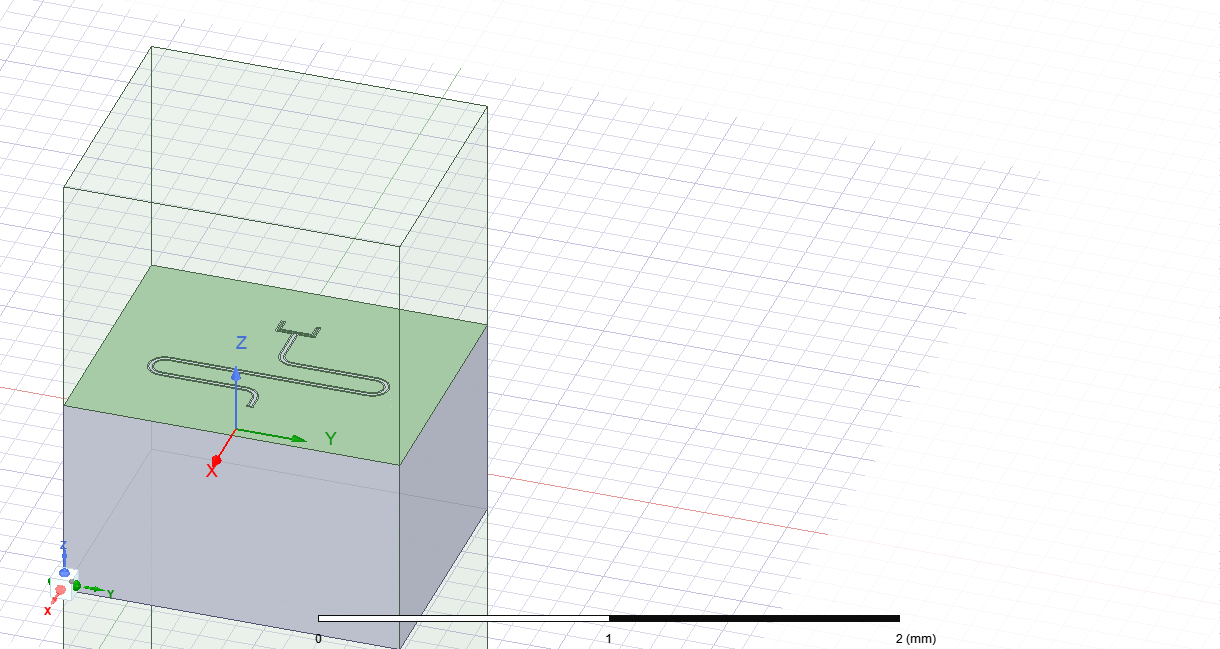

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
freq = 27.117 GHz
Q = 10872731.5
kappa = 0.002 MHz


INFO 04:24PM [connect_design]: 	Opened active design
	Design:    LOMv2.01_q3d28 [Solution type: Q3D]
WARNING 04:24PM [connect_setup]: 	No design setup detected.
WARNING 04:24PM [connect_setup]: 	Creating Q3D default setup.
INFO 04:24PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:25PM [get_setup]: 	Opened setup `default_LOM_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:25PM [analyze]: Analyzing setup default_LOM_setup
INFO 04:25PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpgi9xa34e.txt, C, , default_LOM_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:25PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpkxrvimwk.txt, C, , default_LOM_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:25PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpxktoevpp.txt, C, , default_LO

27117096150.9
184.3855246216713
25617155112.583927
{'claw_opts': {'connection_pads': {'readout': {'connector_location': '90', 'connector_type': '0', 'claw_length': '50um', 'ground_spacing': '10um', 'claw_gap': '5.1um', 'claw_width': '7um', 'claw_cpw_width': '11.7um', 'claw_cpw_length': '0um'}}, 'cross_width': '30um', 'cross_length': '300um', 'cross_gap': '30um', 'orientation': '-90', 'pos_x': '-1000um'}, 'cpw_opts': {'fillet': '49.9um', 'total_length': '2000um', 'trace_width': '11.7um', 'trace_gap': '5.1um', 'lead': {'start_straight': '50um'}, 'pin_inputs': {'start_pin': {'component': 'cplr', 'pin': 'second_end'}, 'end_pin': {'component': 'claw', 'pin': 'readout'}}}, 'cplr_opts': {'prime_width': '11.7um', 'prime_gap': '5.1um', 'second_width': '11.7um', 'second_gap': '5.1um', 'cap_gap': '5um', 'cap_width': '10um', 'cap_gap_ground': '5.1um', 'finger_length': '30um', 'finger_count': '5', 'cap_distance': '50.9um'}}
Starting the Simulation


INFO 04:25PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:25PM [load_ansys_project]: 	Opened Ansys App
INFO 04:25PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:25PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Users/lfl/Documents/Ansoft/
	Project:   Project34_ml_v1star_sims
INFO 04:26PM [connect_design]: 	Opened active design
	Design:    LOMv2.01_q3d28 [Solution type: Q3D]
INFO 04:26PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:26PM [connect]: 	Connected to project "Project34_ml_v1star_sims" and design "LOMv2.01_q3d28" 😀 

INFO 04:27PM [connect_design]: 	Opened active design
	Design:    CavitySweep79 [Solution type: Eigenmode]
WARNING 04:27PM [connect_setup]: 	No design setup detected.
WARNING 04:27PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:27PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


the parameters ['min_converged_passes'] are unsupported, so they have been ignored


INFO 04:28PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


Sim rendered into HFSS!
{'mesh1': {'objects': ['trace_cpw', 'readout_connector_arm_claw'], 'MaxLength': '4um'}}
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path C:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path C:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


INFO:Global:Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


pyaedt INFO: Project Project34_ml_v1star_sims set to active.


INFO:Global:Project Project34_ml_v1star_sims set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 04:29PM [__del__]: Disconnected from Ansys HFSS
INFO 04:29PM [get_setup]: 	Opened setup `test_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:29PM [analyze]: Analyzing setup test_setup
04:30PM 42s INFO [get_f_convergence]: Saved convergences to d:\andre\SQuADDS\tutorials\hfss_eig_f_convergence.csv


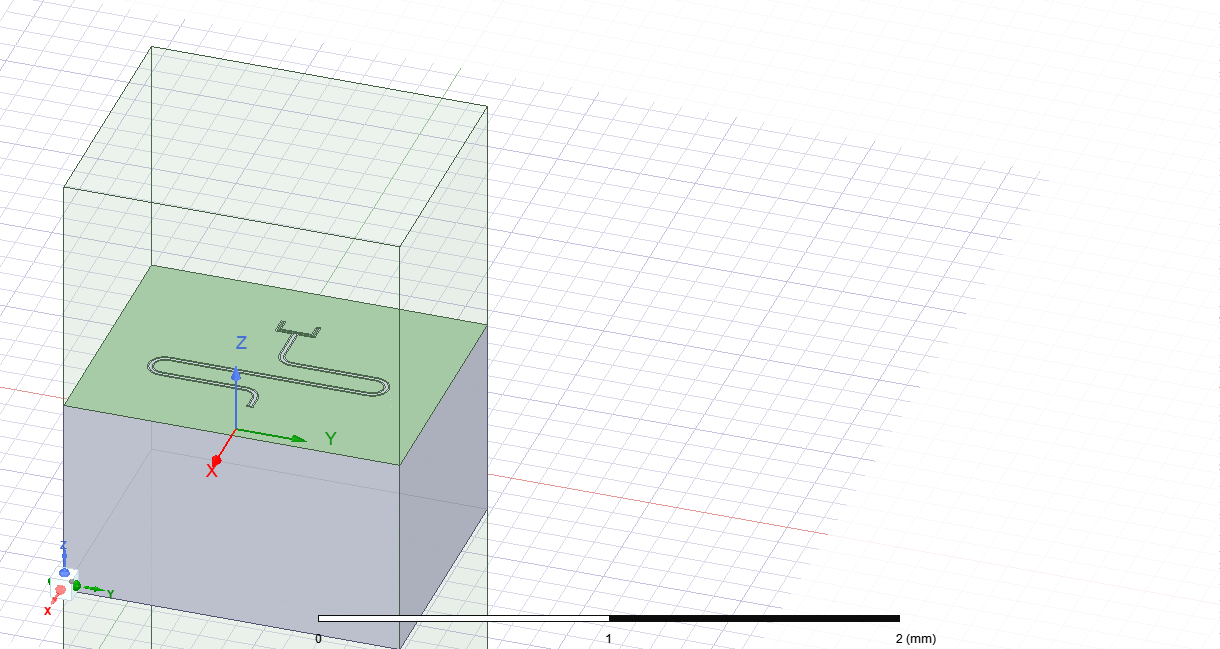

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
freq = 27.117 GHz
Q = 10872731.5
kappa = 0.002 MHz


INFO 04:31PM [connect_design]: 	Opened active design
	Design:    LOMv2.01_q3d29 [Solution type: Q3D]
WARNING 04:31PM [connect_setup]: 	No design setup detected.
WARNING 04:31PM [connect_setup]: 	Creating Q3D default setup.
INFO 04:31PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:32PM [get_setup]: 	Opened setup `default_LOM_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:32PM [analyze]: Analyzing setup default_LOM_setup
INFO 04:32PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpvae1_8yo.txt, C, , default_LOM_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:32PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpan6vdmw1.txt, C, , default_LOM_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:32PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpsqdbm5c2.txt, C, , default_LO

27117096150.9
184.3855246216713
25206550694.758495
{'claw_opts': {'connection_pads': {'readout': {'connector_location': '90', 'connector_type': '0', 'claw_length': '50um', 'ground_spacing': '10um', 'claw_gap': '5.1um', 'claw_width': '7um', 'claw_cpw_width': '11.7um', 'claw_cpw_length': '0um'}}, 'cross_width': '30um', 'cross_length': '300um', 'cross_gap': '30um', 'orientation': '-90', 'pos_x': '-1000um'}, 'cpw_opts': {'fillet': '49.9um', 'total_length': '2000um', 'trace_width': '11.7um', 'trace_gap': '5.1um', 'lead': {'start_straight': '50um'}, 'pin_inputs': {'start_pin': {'component': 'cplr', 'pin': 'second_end'}, 'end_pin': {'component': 'claw', 'pin': 'readout'}}}, 'cplr_opts': {'prime_width': '11.7um', 'prime_gap': '5.1um', 'second_width': '11.7um', 'second_gap': '5.1um', 'cap_gap': '5um', 'cap_width': '10um', 'cap_gap_ground': '5.1um', 'finger_length': '30um', 'finger_count': '7', 'cap_distance': '50.9um'}}
Starting the Simulation


INFO 04:32PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:32PM [load_ansys_project]: 	Opened Ansys App
INFO 04:32PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:32PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Users/lfl/Documents/Ansoft/
	Project:   Project34_ml_v1star_sims
INFO 04:33PM [connect_design]: 	Opened active design
	Design:    LOMv2.01_q3d29 [Solution type: Q3D]
INFO 04:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:33PM [connect]: 	Connected to project "Project34_ml_v1star_sims" and design "LOMv2.01_q3d29" 😀 

INFO 04:34PM [connect_design]: 	Opened active design
	Design:    CavitySweep80 [Solution type: Eigenmode]
WARNING 04:34PM [connect_setup]: 	No design setup detected.
WARNING 04:34PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:34PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


the parameters ['min_converged_passes'] are unsupported, so they have been ignored


INFO 04:35PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


Sim rendered into HFSS!
{'mesh1': {'objects': ['trace_cpw', 'readout_connector_arm_claw'], 'MaxLength': '4um'}}
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path C:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path C:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


INFO:Global:Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


pyaedt INFO: Project Project34_ml_v1star_sims set to active.


INFO:Global:Project Project34_ml_v1star_sims set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 04:36PM [__del__]: Disconnected from Ansys HFSS
INFO 04:36PM [get_setup]: 	Opened setup `test_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:36PM [analyze]: Analyzing setup test_setup
04:37PM 40s INFO [get_f_convergence]: Saved convergences to d:\andre\SQuADDS\tutorials\hfss_eig_f_convergence.csv


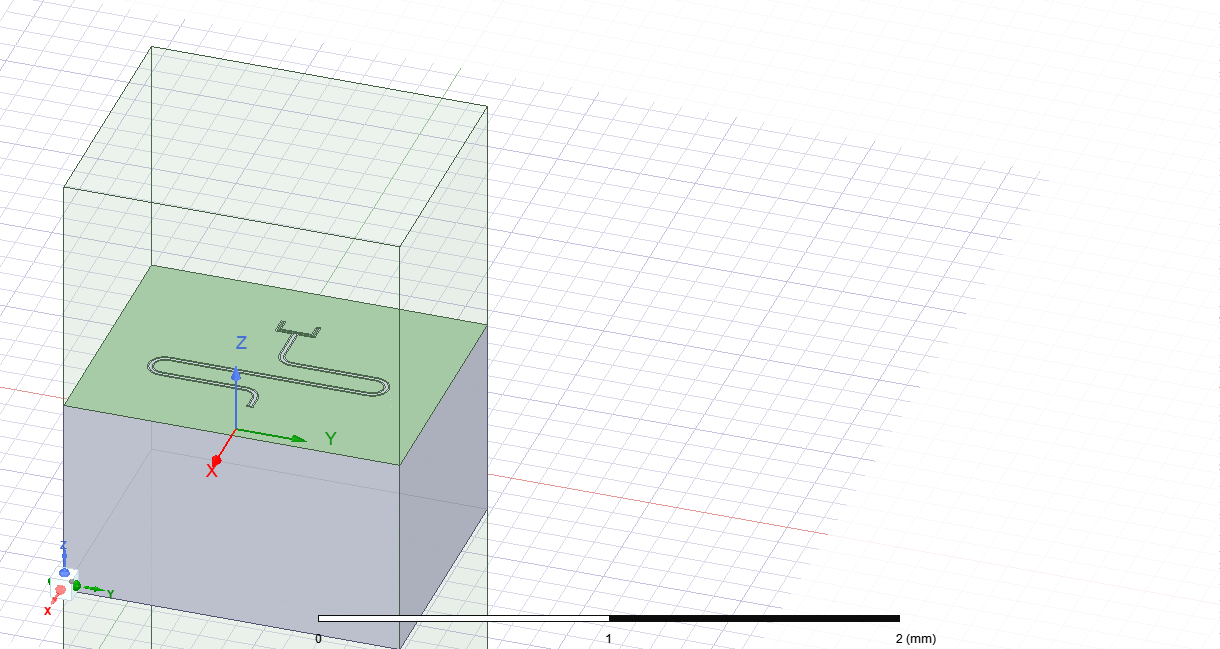

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
freq = 27.117 GHz
Q = 10872731.5
kappa = 0.002 MHz


INFO 04:38PM [connect_design]: 	Opened active design
	Design:    LOMv2.01_q3d30 [Solution type: Q3D]
WARNING 04:38PM [connect_setup]: 	No design setup detected.
WARNING 04:38PM [connect_setup]: 	Creating Q3D default setup.
INFO 04:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:39PM [get_setup]: 	Opened setup `default_LOM_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:39PM [analyze]: Analyzing setup default_LOM_setup
INFO 04:39PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp3nndapmd.txt, C, , default_LOM_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:39PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpu17cugh7.txt, C, , default_LOM_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:39PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmppl3fpxp3.txt, C, , default_LO

27117096150.9
184.3855246216713
24764160482.58818
{'claw_opts': {'connection_pads': {'readout': {'connector_location': '90', 'connector_type': '0', 'claw_length': '50um', 'ground_spacing': '10um', 'claw_gap': '5.1um', 'claw_width': '7um', 'claw_cpw_width': '11.7um', 'claw_cpw_length': '0um'}}, 'cross_width': '30um', 'cross_length': '300um', 'cross_gap': '30um', 'orientation': '-90', 'pos_x': '-1000um'}, 'cpw_opts': {'fillet': '49.9um', 'total_length': '4000um', 'trace_width': '11.7um', 'trace_gap': '5.1um', 'lead': {'start_straight': '50um'}, 'pin_inputs': {'start_pin': {'component': 'cplr', 'pin': 'second_end'}, 'end_pin': {'component': 'claw', 'pin': 'readout'}}}, 'cplr_opts': {'prime_width': '11.7um', 'prime_gap': '5.1um', 'second_width': '11.7um', 'second_gap': '5.1um', 'cap_gap': '5um', 'cap_width': '10um', 'cap_gap_ground': '5.1um', 'finger_length': '30um', 'finger_count': '3', 'cap_distance': '50.9um'}}
Starting the Simulation


INFO 04:39PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:39PM [load_ansys_project]: 	Opened Ansys App
INFO 04:39PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:39PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Users/lfl/Documents/Ansoft/
	Project:   Project34_ml_v1star_sims
INFO 04:40PM [connect_design]: 	Opened active design
	Design:    LOMv2.01_q3d30 [Solution type: Q3D]
INFO 04:40PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:40PM [connect]: 	Connected to project "Project34_ml_v1star_sims" and design "LOMv2.01_q3d30" 😀 

INFO 04:41PM [connect_design]: 	Opened active design
	Design:    CavitySweep81 [Solution type: Eigenmode]
WARNING 04:41PM [connect_setup]: 	No design setup detected.
WARNING 04:41PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:41PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


the parameters ['min_converged_passes'] are unsupported, so they have been ignored


INFO 04:42PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


Sim rendered into HFSS!
{'mesh1': {'objects': ['trace_cpw', 'readout_connector_arm_claw'], 'MaxLength': '4um'}}
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path C:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path C:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


INFO:Global:Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


pyaedt INFO: Project Project34_ml_v1star_sims set to active.


INFO:Global:Project Project34_ml_v1star_sims set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 04:43PM [__del__]: Disconnected from Ansys HFSS
INFO 04:43PM [get_setup]: 	Opened setup `test_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:43PM [analyze]: Analyzing setup test_setup
04:46PM 34s INFO [get_f_convergence]: Saved convergences to d:\andre\SQuADDS\tutorials\hfss_eig_f_convergence.csv


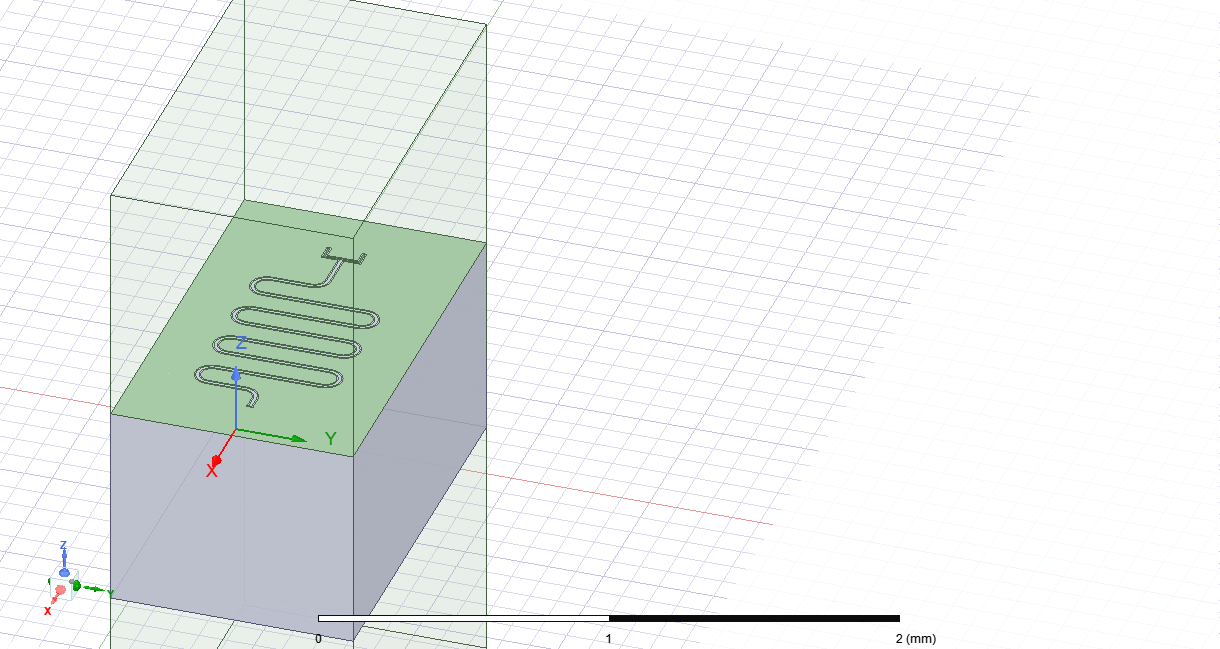

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
freq = 14.283 GHz
Q = 10876443.3
kappa = 0.001 MHz


INFO 04:47PM [connect_design]: 	Opened active design
	Design:    LOMv2.01_q3d31 [Solution type: Q3D]
WARNING 04:47PM [connect_setup]: 	No design setup detected.
WARNING 04:47PM [connect_setup]: 	Creating Q3D default setup.
INFO 04:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:48PM [get_setup]: 	Opened setup `default_LOM_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:48PM [analyze]: Analyzing setup default_LOM_setup


com_error: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024349), None)

In [19]:
ansys_simulator.sweep(ncap_sweep_dict, emode_setup=example_eigenmode_setup, lom_setup=example_LOM_setup)

The sweeper code saves the resuts of every iteration of the sweep into a `json` file, which can be found in the same folder as this Tutorial.

## License

<div style='width: 100%; background-color:#3cb1c2;color:#324344;padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>
    <h3>This code is a part of SQuADDS</h3>
    <p>Developed by Sadman Ahmed Shanto</p>
    <p>This tutorial is written by Andre Kuo</p>
    <p>&copy; Copyright Sadman Ahmed Shanto & Eli Levenson-Falk 2023.</p>
    <p>This code is licensed under the MIT License. You may<br> obtain a copy of this license in the LICENSE.txt file in the root directory<br> of this source tree.</p>
    <p>Any modifications or derivative works of this code must retain this<br>copyright notice, and modified files need to carry a notice indicating<br>that they have been altered from the originals.</p>
</div>